In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
with open('benchmarking_results.json', 'r') as f:
    benchmark_data = json.load(f)
    
benchmark_data

{'llama-wth-not_quantized': {'module': 'pipelines.llama_pipeline',
  'function': 'run_llama_pipeline',
  'args': [],
  'kwargs': {'model_path': 'llama-wth/unsloth.BF16.gguf',
   'prompt_type': 'wth'},
  'dataset_name': 'zpp-murmuras/llama-ds-wth-rev3',
  'splits': {'penny': 'penny_train+penny_test',
   'edeka': 'edeka_train+edeka_test',
   'dm': 'dm_test',
   'lidl': 'lidl_test',
   'rewe': 'rewe_test',
   'rossmann': 'rossmann_test'},
  'threshold': 0.8,
  'expected': {'penny': 67,
   'edeka': 379,
   'dm': 1310,
   'lidl': 1478,
   'rewe': 2751,
   'rossmann': 473},
  'generated': {'penny': 52,
   'edeka': 662,
   'dm': 1541,
   'lidl': 1731,
   'rewe': 3038,
   'rossmann': 460},
  'matched': {'penny': 29,
   'edeka': 45,
   'dm': 997,
   'lidl': 1343,
   'rewe': 2606,
   'rossmann': 431},
  'generation_time': {'penny': 33.52236052299986,
   'edeka': 512.0709547689999,
   'dm': 1096.9037773500004,
   'lidl': 1266.636809306,
   'rewe': 2759.2773036320004,
   'rossmann': 346.1105347720

In [3]:
with open('quantization_comparison/quantization_comparison_results.json', 'r') as f:
    quant_data = json.load(f)
    
quant_data

{'not_quantized': {'prompt_eval_rate': 3.11,
  'generation_rate': 2.0,
  'file_size': 2479591168},
 'q8_0': {'prompt_eval_rate': 12.91,
  'generation_rate': 8.53,
  'file_size': 1321078528},
 'q4_k_m': {'prompt_eval_rate': 27.79,
  'generation_rate': 12.74,
  'file_size': 807689984},
 'q4_0': {'prompt_eval_rate': 40.43,
  'generation_rate': 11.16,
  'file_size': 770924288}}

In [4]:
for experiment in benchmark_data.values():
    experiment['recall'] = {}
    experiment['precision'] = {}
    for dataset in experiment['expected'].keys():
        m = experiment['matched'][dataset]
        g = experiment['generated'][dataset]
        e = experiment['expected'][dataset]
        experiment['recall'][dataset] = m / e if e > 0 else 0
        experiment['precision'][dataset] = m / g if g > 0 else 0

benchmark_data

{'llama-wth-not_quantized': {'module': 'pipelines.llama_pipeline',
  'function': 'run_llama_pipeline',
  'args': [],
  'kwargs': {'model_path': 'llama-wth/unsloth.BF16.gguf',
   'prompt_type': 'wth'},
  'dataset_name': 'zpp-murmuras/llama-ds-wth-rev3',
  'splits': {'penny': 'penny_train+penny_test',
   'edeka': 'edeka_train+edeka_test',
   'dm': 'dm_test',
   'lidl': 'lidl_test',
   'rewe': 'rewe_test',
   'rossmann': 'rossmann_test'},
  'threshold': 0.8,
  'expected': {'penny': 67,
   'edeka': 379,
   'dm': 1310,
   'lidl': 1478,
   'rewe': 2751,
   'rossmann': 473},
  'generated': {'penny': 52,
   'edeka': 662,
   'dm': 1541,
   'lidl': 1731,
   'rewe': 3038,
   'rossmann': 460},
  'matched': {'penny': 29,
   'edeka': 45,
   'dm': 997,
   'lidl': 1343,
   'rewe': 2606,
   'rossmann': 431},
  'generation_time': {'penny': 33.52236052299986,
   'edeka': 512.0709547689999,
   'dm': 1096.9037773500004,
   'lidl': 1266.636809306,
   'rewe': 2759.2773036320004,
   'rossmann': 346.1105347720

# Model comparisons

In [5]:
def model_comparison_barplot(model_1_score_dict, model_2_score_dict, model_1_name, model_2_name, ylabel, filename):
    benchmarks = list(model_1_score_dict.keys())
    llama_wth_vals = [model_1_score_dict[b] for b in benchmarks]
    llama_w_vals = [model_2_score_dict[b] for b in benchmarks]

    x = np.arange(len(benchmarks))
    width = 0.35

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, llama_wth_vals, width, label=model_1_name)
    bars2 = ax.bar(x + width/2, llama_w_vals, width, label=model_2_name)

    ax.set_ylabel(ylabel)
    ax.set_title(f'{model_1_name} vs {model_2_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks)
    ax.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

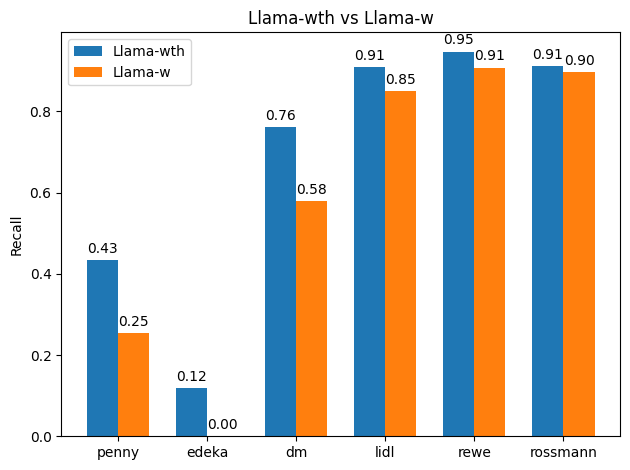

In [6]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['recall'],
    benchmark_data['llama-w-not_quantized']['recall'],
    'Llama-wth',
    'Llama-w',
    'Recall',
    'llama_wth_vs_w_recall'
)

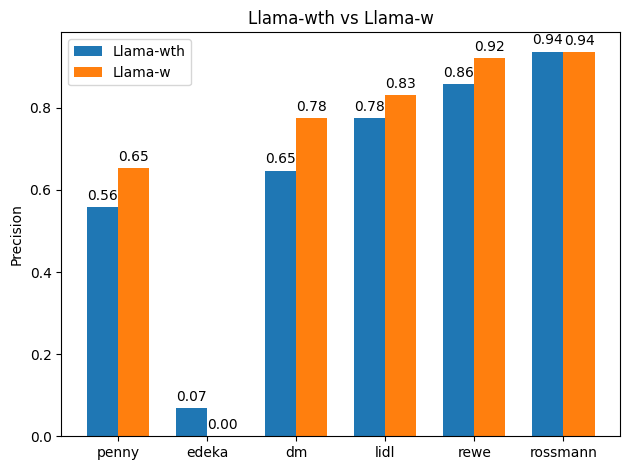

In [7]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['precision'],
    benchmark_data['llama-w-not_quantized']['precision'],
    'Llama-wth',
    'Llama-w',
    'Precision',
    'llama_wth_vs_w_precision'
)

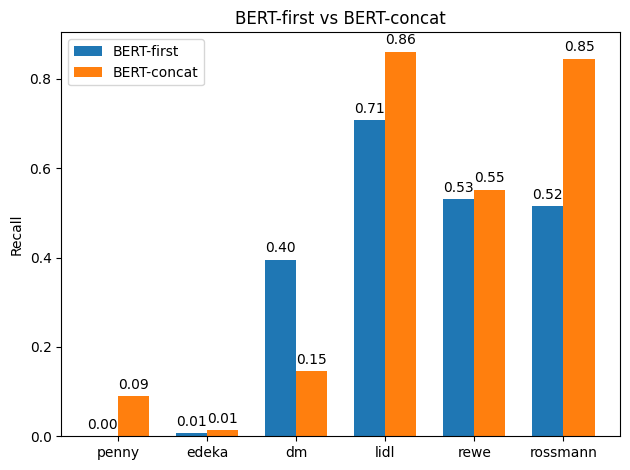

In [8]:
model_comparison_barplot(
    benchmark_data['bert-no-curr-first']['recall'],
    benchmark_data['bert-no-curr-concat']['recall'],
    'BERT-first',
    'BERT-concat',
    'Recall',
    'bert_first_vs_concat_recall'
)

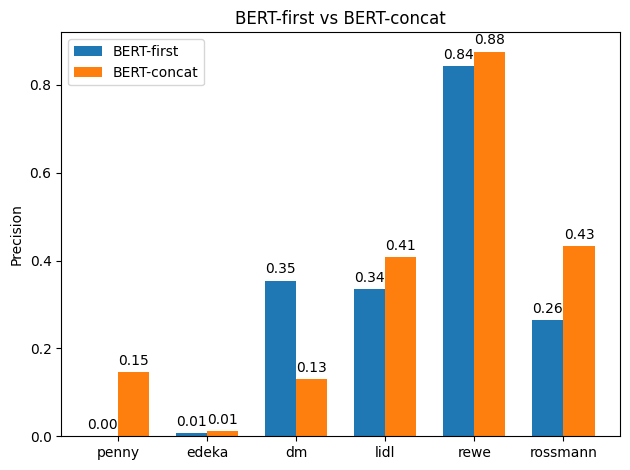

In [9]:
model_comparison_barplot(
    benchmark_data['bert-no-curr-first']['precision'],
    benchmark_data['bert-no-curr-concat']['precision'],
    'BERT-first',
    'BERT-concat',
    'Precision',
    'bert_first_vs_concat_precision'
)

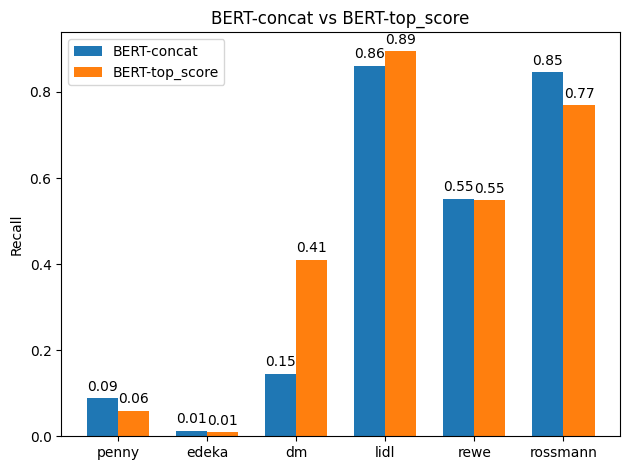

In [10]:
model_comparison_barplot(
    benchmark_data['bert-no-curr-concat']['recall'],
    benchmark_data['bert-no-curr-top_score']['recall'],
    'BERT-concat',
    'BERT-top_score',
    'Recall',
    'bert_concat_vs_top_score_recall'
)

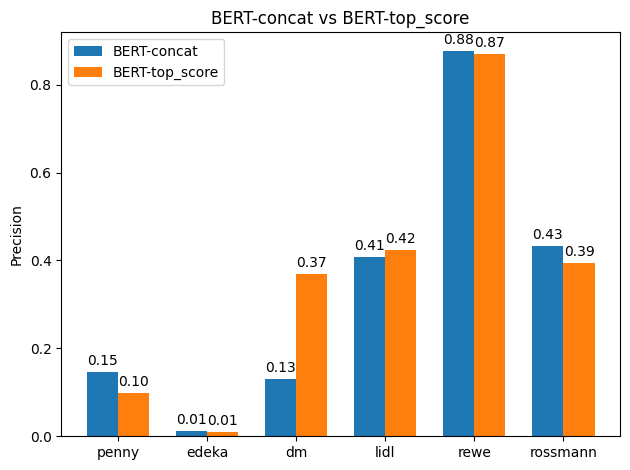

In [11]:
model_comparison_barplot(
    benchmark_data['bert-no-curr-concat']['precision'],
    benchmark_data['bert-no-curr-top_score']['precision'],
    'BERT-concat',
    'BERT-top_score',
    'Precision',
    'bert_concat_vs_top_score_precision'
)

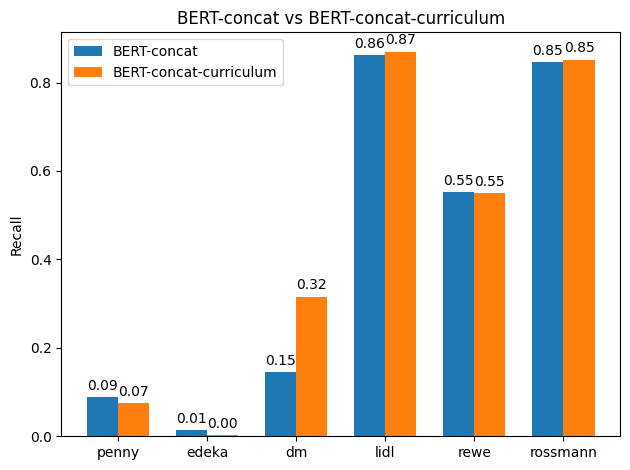

In [12]:
model_comparison_barplot(
    benchmark_data['bert-no-curr-concat']['recall'],
    benchmark_data['bert-curr-concat']['recall'],
    'BERT-concat',
    'BERT-concat-curriculum',
    'Recall',
    'bert_no_curr_vs_curr_recall'
)

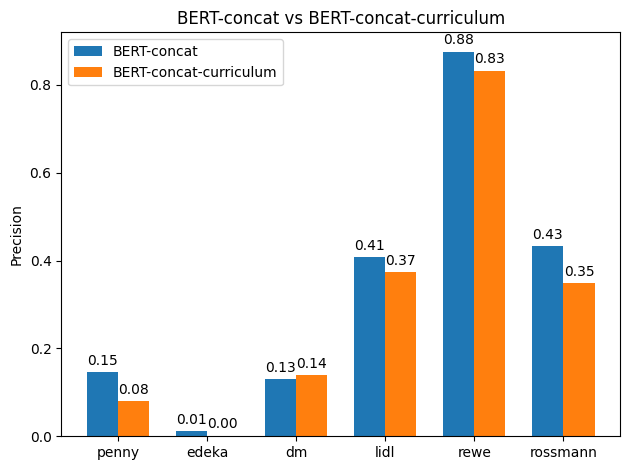

In [13]:
model_comparison_barplot(
    benchmark_data['bert-no-curr-concat']['precision'],
    benchmark_data['bert-curr-concat']['precision'],
    'BERT-concat',
    'BERT-concat-curriculum',
    'Precision',
    'bert_no_curr_vs_curr_precision'
)

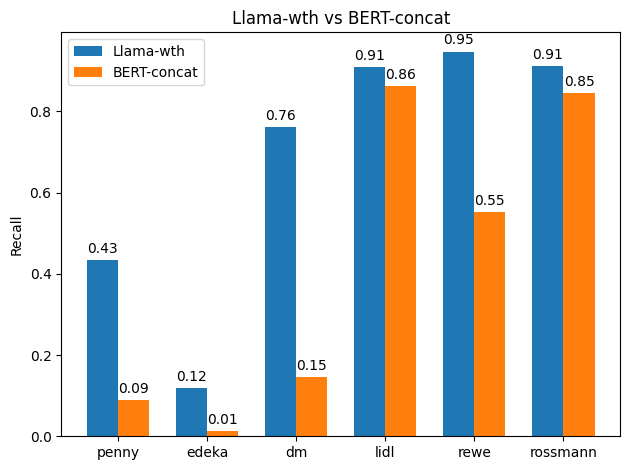

In [14]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['recall'],
    benchmark_data['bert-no-curr-concat']['recall'],
    'Llama-wth',
    'BERT-concat',
    'Recall',
    'llama_vs_bert_recall'
)

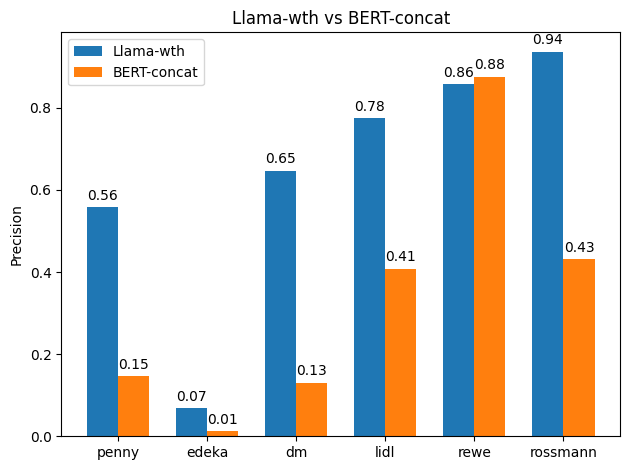

In [15]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['precision'],
    benchmark_data['bert-no-curr-concat']['precision'],
    'Llama-wth',
    'BERT-concat',
    'Precision',
    'llama_vs_bert_precision'
)

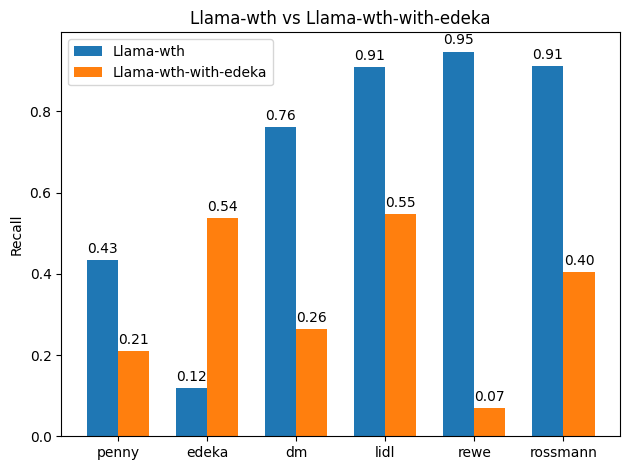

In [16]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['recall'],
    benchmark_data['llama-wth-with-edeka']['recall'],
    'Llama-wth',
    'Llama-wth-with-edeka',
    'Recall',
    'llama_vs_llama_with_edeka_recall'
)

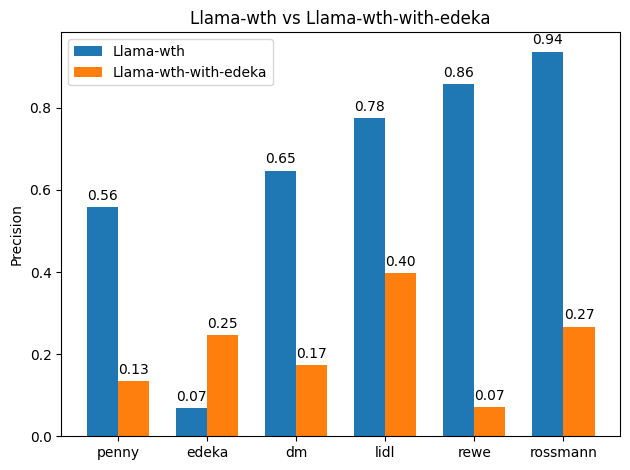

In [17]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['precision'],
    benchmark_data['llama-wth-with-edeka']['precision'],
    'Llama-wth',
    'Llama-wth-with-edeka',
    'Precision',
    'llama_vs_llama_with_edeka_precision'
)

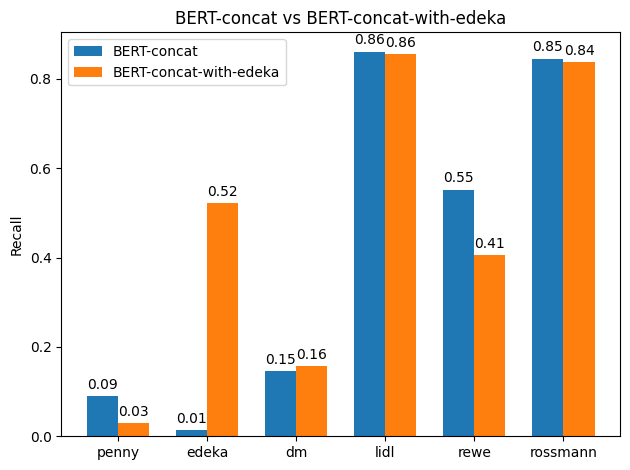

In [18]:
model_comparison_barplot(
    benchmark_data['bert-no-curr-concat']['recall'],
    benchmark_data['bert-with-edeka']['recall'],
    'BERT-concat',
    'BERT-concat-with-edeka',
    'Recall',
    'bert_vs_bert_with_edeka_recall'
)

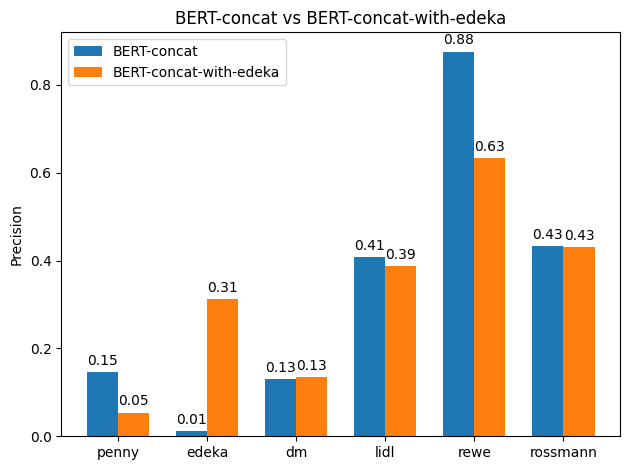

In [19]:
model_comparison_barplot(
    benchmark_data['bert-no-curr-concat']['precision'],
    benchmark_data['bert-with-edeka']['precision'],
    'BERT-concat',
    'BERT-concat-with-edeka',
    'Precision',
    'bert_vs_bert_with_edeka_precision'
)

# Quantizations

In [20]:
quantized_model_names = ['llama-wth-not_quantized', 'llama-wth-q8_0', 'llama-wth-q4_k_m', 'llama-wth-q4_0']
quantizations = ['not_quantized', 'q8_0', 'q4_k_m', 'q4_0']
quantization_labels = ['Not Quantized', 'Q8_0', 'Q4_K_M', 'Q4_0']

In [21]:
def quant_comparision_plot(metric, title, ylabel, filename):
    penny_results = [benchmark_data[m][metric]['penny'] for m in quantized_model_names]
    edeka_results = [benchmark_data[m][metric]['edeka'] for m in quantized_model_names]
    dm_results = [benchmark_data[m][metric]['dm'] for m in quantized_model_names]
    lidl_results = [benchmark_data[m][metric]['lidl'] for m in quantized_model_names]
    rewe_results = [benchmark_data[m][metric]['rewe'] for m in quantized_model_names]
    rossmann_results = [benchmark_data[m][metric]['rossmann'] for m in quantized_model_names]

    plt.plot(quantization_labels, penny_results, marker='o', label='penny')
    plt.plot(quantization_labels, edeka_results, marker='s', label='edeka')
    plt.plot(quantization_labels, dm_results, marker='^', label='dm')
    plt.plot(quantization_labels, lidl_results, marker='d', label='lidl')
    plt.plot(quantization_labels, rewe_results, marker='<', label='rewe')
    plt.plot(quantization_labels, rossmann_results, marker='>', label='rossmann')

    plt.title(title)
    plt.xlabel('Quantization')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

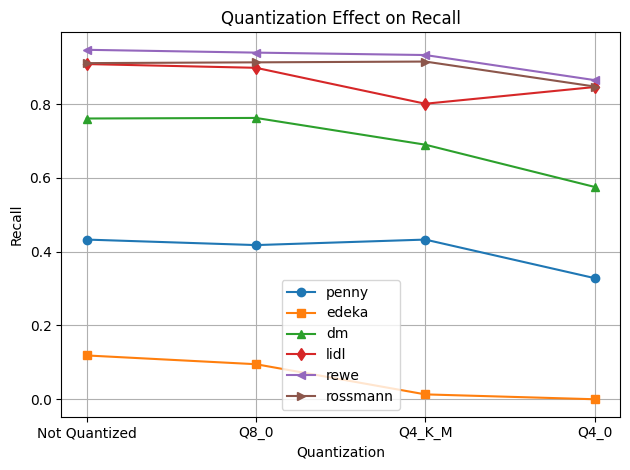

In [22]:
quant_comparision_plot(
    'recall', 
    'Quantization Effect on Recall', 
    'Recall', 
    'quantization_effect_on_recall'
)

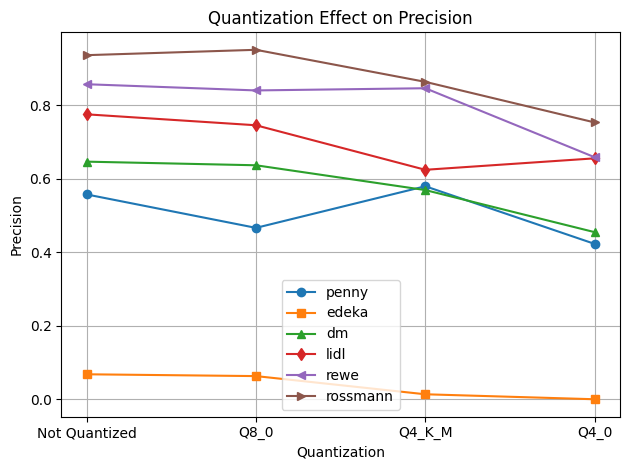

In [23]:
quant_comparision_plot(
    'precision', 
    'Quantization Effect on Precision', 
    'Precision', 
    'quantization_effect_on_precision'
)

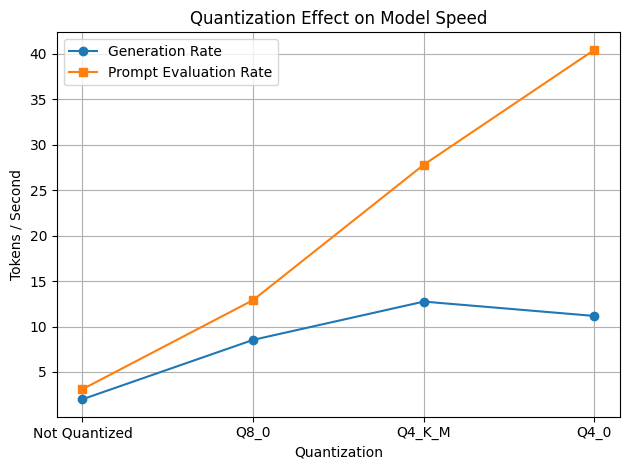

In [24]:
generation_rates = [quant_data[m]['generation_rate'] for m in quantizations]
prompt_eval_rates = [quant_data[m]['prompt_eval_rate'] for m in quantizations]

plt.plot(quantization_labels, generation_rates, marker='o', label='Generation Rate')
plt.plot(quantization_labels, prompt_eval_rates, marker='s', label='Prompt Evaluation Rate')

plt.title('Quantization Effect on Model Speed')
plt.xlabel('Quantization')
plt.ylabel('Tokens / Second')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('quantization_effect_on_model_speed', dpi=300, bbox_inches='tight')
plt.show()

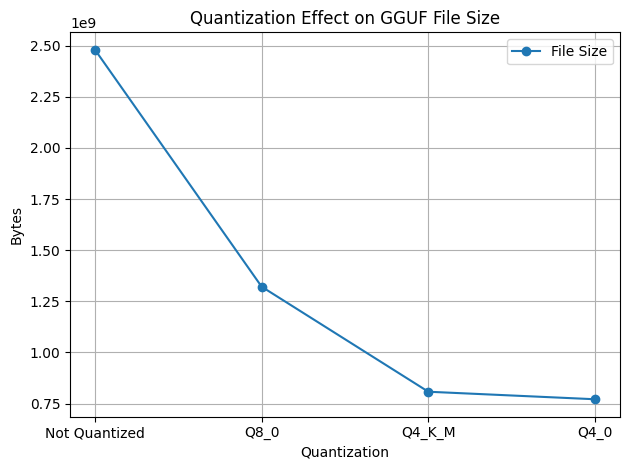

In [25]:
file_sizes = [quant_data[m]['file_size'] for m in quantizations]

plt.plot(quantization_labels, file_sizes, marker='o', label='File Size')

plt.title('Quantization Effect on GGUF File Size')
plt.xlabel('Quantization')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('quantization_effect_on_gguf_file_size', dpi=300, bbox_inches='tight')
plt.show()

# Appwise

In [26]:
def appwise_barplot(pipeline_pref, metric, title, ylabel, filename):
    apps = ['dm', 'lidl', 'rewe', 'rossmann']
    values = [benchmark_data[pipeline_pref + '-' + app][metric][app] for app in apps]
    
    plt.bar(apps, values)
    plt.ylabel(ylabel)
    plt.title(title)

    for i, v in enumerate(values):
        plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

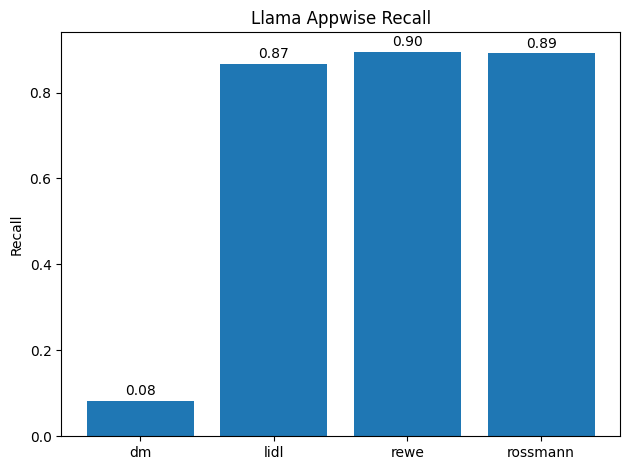

In [27]:
appwise_barplot(
    'llama-wth-appwise', 
    'recall', 
    'Llama Appwise Recall', 
    'Recall', 
    'llama-wth-appwise-recall'
)

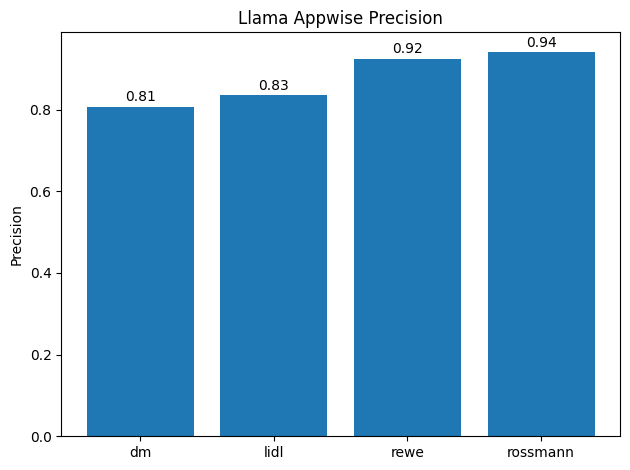

In [28]:
appwise_barplot(
    'llama-wth-appwise', 
    'precision', 
    'Llama Appwise Precision', 
    'Precision', 
    'llama-wth-appwise-precision'
)

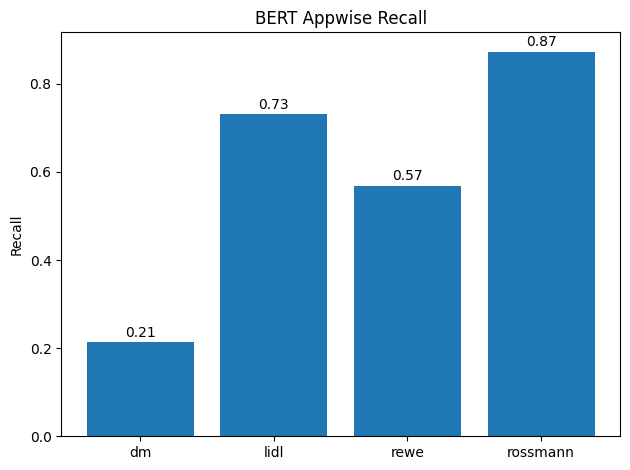

In [29]:
appwise_barplot(
    'bert-single-app', 
    'recall', 
    'BERT Appwise Recall', 
    'Recall', 
    'bert-appwise-recall'
)

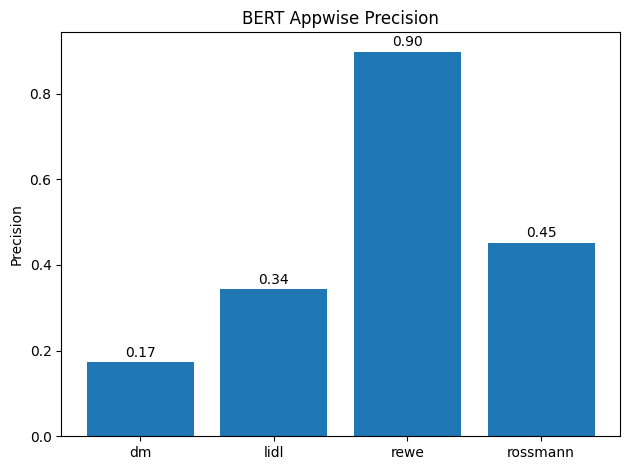

In [30]:
appwise_barplot(
    'bert-single-app', 
    'precision', 
    'BERT Appwise Precision', 
    'Precision', 
    'bert-appwise-precision'
)